<a href="https://colab.research.google.com/github/luckyos-code/X-COVID/blob/main/multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*OLD VERSION, SEE BINARY FOR UPDATE*
# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Pneumonia vs Normal)

##### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Init Kaggle-API
**Important:** Before running the cells below follow [this](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab) stackoverflow questions accepted answer to get the kaggle.json file. Once you have the json file on your local machine,run the code below and upload the json file when prompted in the output cell. ([credit](https://github.com/mobassir94/Practicing-Tensorflow/blob/master/kaggle_Pneumonia_Detection.ipynb))

**Important:** Before running the cells below follow [this link](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge) click on 'Late Submission' and when prompted accept the competition rules.

In [ ]:
!pip uninstall -q -y kaggle
!pip install -q --upgrade pip
!pip install -q kaggle==1.5.6
!mkdir  /root/.kaggle
from google.colab import files as colab
colab.upload()
!cp kaggle.json /root/.kaggle && chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json

     |████████████████████████████████| 1.5MB 8.0MB/s 
     |████████████████████████████████| 58 kB 4.6 MB/s 


Saving kaggle.json to kaggle.json


##### Download datasets

###### *COVIDx dataset* [Github](https://github.com/lindawangg/COVID-Net) 

In [ ]:
!git clone https://github.com/lindawangg/COVID-Net

Cloning into 'COVID-Net'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 614 (delta 76), reused 62 (delta 30), pack-reused 478
Receiving objects: 100% (614/614), 7.30 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (361/361), done.


###### *COVID-19 image data collection*
J.P. Cohen, P. Morrison, L. Dao.
COVID-19 image data collection.
(2020)
[Github](https://github.com/ieee8023/covid-chestxray-dataset)
[Google Scholar](https://scholar.google.com/scholar_lookup?title=COVID-19%20image%20data%20collection&publication_year=2020&author=J.P.%20Cohen&author=P.%20Morrison&author=L.%20Dao)

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3622 (delta 3), reused 2 (delta 0), pack-reused 3614
Receiving objects: 100% (3622/3622), 632.88 MiB | 43.74 MiB/s, done.
Resolving deltas: 100% (1436/1436), done.
Checking out files: 100% (1173/1173), done.


###### *Figure 1 COVID-19 Chest X-ray Dataset Initiative* [Github](https://github.com/agchung/Figure1-COVID-chestxray-dataset)

In [ ]:
!git clone https://github.com/agchung/Figure1-COVID-chestxray-dataset.git

Cloning into 'Figure1-COVID-chestxray-dataset'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 112 (delta 28), reused 95 (delta 14), pack-reused 0
Receiving objects: 100% (112/112), 14.13 MiB | 42.30 MiB/s, done.
Resolving deltas: 100% (28/28), done.


###### *Actualmed COVID-19 Chest X-ray Dataset Initiative* [Github](https://github.com/agchung/Actualmed-COVID-chestxray-dataset)


In [ ]:
!git clone https://github.com/agchung/Actualmed-COVID-chestxray-dataset.git

Cloning into 'Actualmed-COVID-chestxray-dataset'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 422 (delta 1), reused 6 (delta 1), pack-reused 412
Receiving objects: 100% (422/422), 1.56 GiB | 33.19 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (240/240), done.


###### *COVID-19 Radiography Database*  
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam,
“Can AI help in screening Viral and COVID-19 pneumonia?”
(2020)
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

**Important:** Before running the cell below follow [this](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab) stackoverflow questions accepted answer to get the kaggle.json file. Once you have the json file on your local machine,run the code below and upload the json file there. ([credit](https://github.com/mobassir94/Practicing-Tensorflow/blob/master/kaggle_Pneumonia_Detection.ipynb))

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip -q covid19-radiography-database.zip
!rm covid19-radiography-database.zip

 99% 1.14G/1.15G [00:26<00:00, 55.3MB/s]
100% 1.15G/1.15G [00:26<00:00, 46.8MB/s]


###### *RSNA Pneumonia Detection Challenge*
Radiological Society of North America
(2018)
[Kaggle](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)

Based on: Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

**Important:** Before running the cell below follow [this link](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge) click on 'Late Submission' and when prompted accept the competition rules.

In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge -p 'rsna-pneumonia-detection-challenge'
!unzip -q rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge.zip -d rsna-pneumonia-detection-challenge
!rm rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge.zip

100% 3.65G/3.66G [01:38<00:00, 37.1MB/s]
100% 3.66G/3.66G [01:39<00:00, 39.7MB/s]


###### Install packages

In [ ]:
!pip install -q pydicom

     |████████████████████████████████| 1.9 MB 7.7 MB/s 


##### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pydicom as dicom
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight

import keras
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, Flatten, ZeroPadding2D
from keras import layers
from tensorflow.keras.applications import ResNet50V2, EfficientNetB4
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam

import os, shutil, random, cv2
from shutil import copyfile
from distutils.dir_util import copy_tree
from tqdm import tqdm

##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 8
IMG_SIZE = [224, 224]
EPOCHS = 20
# train/test split
SPLIT = 0.15
IMBALANCE_RATIO = 1.5
# Reset the seed so all runs are the same.
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

## Data
**COVIDx dataset:** [Github](https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md)  
L. Wang, Z. Q. Lin, & A. Wong.
Covid-net: A tailored deep convolutional neural network design for detection of covid-19 cases from chest x-ray images.
(2020)
[Github](https://github.com/lindawangg/COVID-Net)
[Google Scholar](https://scholar.google.com/scholar?cluster=12232147793008983229&hl=en&as_sdt=0,5)



### Create dataset

Adapted from [Covidx dataset creation](https://github.com/lindawangg/COVID-Net/blob/master/create_COVIDx.ipynb)

In [ ]:
!mkdir data && mkdir data/images

In [ ]:
savepath = 'data'

# path to covid-19 dataset from https://github.com/ieee8023/covid-chestxray-dataset
cohen_imgpath = 'covid-chestxray-dataset/images' 
cohen_csvpath = 'covid-chestxray-dataset/metadata.csv'

# path to covid-19 dataset from https://github.com/agchung/Figure1-COVID-chestxray-dataset
fig1_imgpath = 'Figure1-COVID-chestxray-dataset/images'
fig1_csvpath = 'Figure1-COVID-chestxray-dataset/metadata.csv'

# path to covid-19 dataset from https://github.com/agchung/Actualmed-COVID-chestxray-dataset
actmed_imgpath = 'Actualmed-COVID-chestxray-dataset/images'
actmed_csvpath = 'Actualmed-COVID-chestxray-dataset/metadata.csv'

# path to covid-19 dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
sirm_imgpath = 'COVID-19_Radiography_Dataset/COVID'
sirm_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
rsna_datapath = 'rsna-pneumonia-detection-challenge'
# get all the normal from here
rsna_csvname = 'stage_2_detailed_class_info.csv' 
# get all the 1s from here since 1 indicate pneumonia
# found that images that aren't pneunmonia and also not normal are classified as 0s
rsna_csvname2 = 'stage_2_train_labels.csv' 
rsna_imgpath = 'stage_2_train_images'

# parameters for COVIDx dataset
metadata = []
class_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}

mapping = dict()
mapping['COVID-19'] = 'COVID-19'
mapping['SARS'] = 'pneumonia'
mapping['MERS'] = 'pneumonia'
mapping['Streptococcus'] = 'pneumonia'
mapping['Klebsiella'] = 'pneumonia'
mapping['Chlamydophila'] = 'pneumonia'
mapping['Legionella'] = 'pneumonia'
mapping['E.Coli'] = 'pneumonia'
mapping['Normal'] = 'normal'
mapping['Lung Opacity'] = 'pneumonia'
mapping['1'] = 'pneumonia'

# to avoid duplicates
patient_imgpath = {}

In [ ]:
# adapted from https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/datasets.py#L814
cohen_csv = pd.read_csv(cohen_csvpath, nrows=None)
#idx_pa = csv["view"] == "PA"  # Keep only the PA view
views = ["PA", "AP", "AP Supine", "AP semi erect", "AP erect"]
cohen_idx_keep = cohen_csv.view.isin(views)
cohen_csv = cohen_csv[cohen_idx_keep]

fig1_csv = pd.read_csv(fig1_csvpath, encoding='ISO-8859-1', nrows=None)
actmed_csv = pd.read_csv(actmed_csvpath, nrows=None)

sirm_csv = pd.read_excel(sirm_csvpath)

In [ ]:
# get non-COVID19 viral, bacteria, and COVID-19 infections from covid-chestxray-dataset, figure1 and actualmed
# stored as patient id, image filename and label
filename_label = {'normal': [], 'pneumonia': [], 'COVID-19': []}
count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}
covid_ds = {'cohen': [], 'fig1': [], 'actmed': [], 'sirm': []}

for index, row in cohen_csv.iterrows():
    f = row['finding'].split('/')[-1] # take final finding in hierarchy, for the case of COVID-19, ARDS
    if f in mapping: # 
        count[mapping[f]] += 1
        entry = [str(row['patientid']), row['filename'], mapping[f], 'cohen']
        filename_label[mapping[f]].append(entry)
        if mapping[f] == 'COVID-19':
            covid_ds['cohen'].append(str(row['patientid']))
        
for index, row in fig1_csv.iterrows():
    if not str(row['finding']) == 'nan':
        f = row['finding'].split(',')[0] # take the first finding
        if f in mapping: # 
            count[mapping[f]] += 1
            if os.path.exists(os.path.join(fig1_imgpath, row['patientid'] + '.jpg')):
                entry = [row['patientid'], row['patientid'] + '.jpg', mapping[f], 'fig1']
            elif os.path.exists(os.path.join(fig1_imgpath, row['patientid'] + '.png')):
                entry = [row['patientid'], row['patientid'] + '.png', mapping[f], 'fig1']
            filename_label[mapping[f]].append(entry)
            if mapping[f] == 'COVID-19':
                covid_ds['fig1'].append(row['patientid'])

for index, row in actmed_csv.iterrows():
    if not str(row['finding']) == 'nan':
        f = row['finding'].split(',')[0]
        if f in mapping:
            count[mapping[f]] += 1
            entry = [row['patientid'], row['imagename'], mapping[f], 'actmed']
            filename_label[mapping[f]].append(entry)
            if mapping[f] == 'COVID-19':
                covid_ds['actmed'].append(row['patientid'])
    
sirm = set(sirm_csv['URL'])
cohen = set(cohen_csv['url'])
discard = ['100', '101', '102', '103', '104', '105', 
           '110', '111', '112', '113', '122', '123', 
           '124', '125', '126', '217']

for idx, row in sirm_csv.iterrows():
    patientid = row['FILE NAME']
    if row['URL'] not in cohen and patientid[patientid.find('(')+1:patientid.find(')')] not in discard:
        count[mapping['COVID-19']] += 1
        imagename = patientid + '.' + row['FORMAT'].lower()
        if not os.path.exists(os.path.join(sirm_imgpath, imagename)):
            imagename = patientid.split('(')[0] + ' ('+ patientid.split('(')[1] + '.' + row['FORMAT'].lower()
        entry = [patientid, imagename, mapping['COVID-19'], 'sirm']
        filename_label[mapping['COVID-19']].append(entry)
        covid_ds['sirm'].append(patientid)
    
print('Data distribution from covid datasets:')
print(count)

Data distribution from covid datasets:
{'normal': 0, 'pneumonia': 57, 'COVID-19': 617}


In [ ]:
# add covid-chestxray-dataset, figure1 and actualmed into dataset
ds_imgpath = {'cohen': cohen_imgpath, 'fig1': fig1_imgpath, 'actmed': actmed_imgpath, 'sirm': sirm_imgpath}

for key in filename_label.keys():
    arr = np.array(filename_label[key])
    # go through all the patients
    for patient in arr:
        #if patient[0] not in patient_imgpath:
        #    patient_imgpath[patient[0]] = [patient[1]]
        #else:
        #    if patient[1] not in patient_imgpath[patient[0]]:
        #        patient_imgpath[patient[0]].append(patient[1])
        #    else:
        #        continue  # skip since image has already been written
        if patient[3] == 'sirm':
            image = cv2.imread(os.path.join(ds_imgpath[patient[3]], patient[1]))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            patient[1] = patient[1].replace(' ', '')
            cv2.imwrite(os.path.join(savepath, 'images', patient[1]), gray)
        else:
            copyfile(os.path.join(ds_imgpath[patient[3]], patient[1]), os.path.join(savepath, 'images', patient[1]))
        metadata.append(patient)
        class_count[patient[2]] += 1

print('class count: ', class_count)

class count:  {'normal': 0, 'pneumonia': 57, 'COVID-19': 617}


In [ ]:
# add normal and rest of pneumonia cases from https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
csv_normal = pd.read_csv(os.path.join(rsna_datapath, rsna_csvname), nrows=None)
csv_pneu = pd.read_csv(os.path.join(rsna_datapath, rsna_csvname2), nrows=None)
patients = {'normal': [], 'pneumonia': []}

for index, row in csv_normal.iterrows():
    if row['class'] == 'Normal':
        patients['normal'].append(row['patientId'])

for index, row in csv_pneu.iterrows():
    if int(row['Target']) == 1:
        patients['pneumonia'].append(row['patientId'])
skipcount = 0
for key in patients.keys():
    arr = np.array(patients[key])
    if arr.size == 0:
        continue
    for patient in arr:
        if patient not in patient_imgpath:
            patient_imgpath[patient] = [patient]
        else:
            skipcount += 1
            continue  # skip since image has already been written
        ds = dicom.dcmread(os.path.join(rsna_datapath, rsna_imgpath, patient + '.dcm'))
        pixel_array_numpy = ds.pixel_array
        imgname = patient + '.png'
        cv2.imwrite(os.path.join(savepath, 'images', imgname), pixel_array_numpy)
        metadata.append([patient, imgname, key, 'rsna'])
        class_count[key] += 1
print(skipcount)
print('class count: ', class_count)

3543
class count:  {'normal': 8851, 'pneumonia': 6069, 'COVID-19': 617}


In [ ]:
# final stats
print('Final stats')
print('Class count: ', class_count)
print('Total images: ', len(metadata))

Final stats
Class count:  {'normal': 8851, 'pneumonia': 6069, 'COVID-19': 617}
Total images:  15537


In [ ]:
# export to metadata csv
# format as patientid, filename, label, separated by a space
metadata_file = open("data/metadata.csv",'w') 
metadata_file.write('patientid filename label source\n')
for sample in metadata:
    if len(sample) == 4:
        info = str(sample[0]) + ' ' + sample[1] + ' ' + sample[2] + ' ' + sample[3] + '\n'
    else:
        info = str(sample[0]) + ' ' + sample[1] + ' ' + sample[2] + '\n'
    metadata_file.write(info)

metadata_file.close()

# TODO get split from covid-net repo
# num_diff_patients = len(np.unique(arr))
# num_test = max(1, round(split*num_diff_patients))
#test_patients = np.load('COVID-Net/rsna_test_patients_{}.npy'.format(key)) # random.sample(list(arr), num_test), download the .npy files from the repo.
# np.save('rsna_test_patients_{}.npy'.format(key), np.array(test_patients))

Delete obsolete files

In [ ]:
!find . -maxdepth 1 ! -name "data" !  -exec rm -r {} \;

rm: refusing to remove '.' or '..' directory: skipping '.'


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(path, label_encoding):
    imgpath = datapath + '/images'
    csv = pd.read_csv(datapath + '/metadata.csv', sep=' ')
    filenames = []
    y_labels = []

    # COVID-19
    covid = csv[csv['label'] == 'COVID-19']
    filenames.extend([imgpath + '/' + s for s in list(covid['filename'])])
    y_labels.extend([label_encoding.index(label) for label in list(covid['label'])])
    # pneumonia
    pneumonia = csv[csv['label'] == 'pneumonia'].sample(int(IMBALANCE_RATIO*len(covid)))
    filenames.extend([imgpath + '/' + s for s in list(pneumonia['filename'])])
    y_labels.extend([label_encoding.index(label) for label in list(pneumonia['label'])])
    # normal
    normal = csv[csv['label'] == 'normal'].sample(int(IMBALANCE_RATIO*len(covid)))
    filenames.extend([imgpath + '/' + s for s in list(normal['filename'])])
    y_labels.extend([label_encoding.index(label) for label in list(normal['label'])])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapath = 'data'
label_encoding = ['normal', 'pneumonia', 'COVID-19'] # normal = 0, pneumonia = 1, COVID-19 = 2

files, labels = get_data(datapath, label_encoding)

###### Create train-test split

In [ ]:
# create train-val-test split
x_train, x_val, y_train, y_val = train_test_split(files, labels, test_size=2*SPLIT, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=random_state)

In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'pneumonia': np.count_nonzero(y == 1),
            'COVID-19': np.count_nonzero(y == 2)}

In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set:   ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 655, 'pneumonia': 644, 'COVID-19': 427}
val set:    {'normal': 137, 'pneumonia': 133, 'COVID-19': 100}
test set:   {'normal': 133, 'pneumonia': 148, 'COVID-19': 90}


###### Create tensors

In [ ]:
# one hot encoding for multi class classification
y_train_one_hot = to_categorical(y_train, 3)
y_val_one_hot = to_categorical(y_val, 3)
y_test_one_hot = to_categorical(y_test, 3)
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val_one_hot))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot))

###### Image retrieval

In [ ]:
def get_img(x, y):
    file_path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    # make sure img has desired number of channels
    # rgb = 3, grayscale = 1
    img = tf.cond(tf.shape(img)[2] == 1, lambda: tf.image.grayscale_to_rgb(img), lambda: img)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_ds).numpy()
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 1726, Val: 370, Test: 371


### Prepare for training

###### Define preprocessing

In [ ]:
# ideas
#   1. crop top, sometimes there is text in the top part of the image
#   2. central crop, crop the central region of the image with an area
#      containing 87.5% of the original image
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])

###### Define data augmentation

In [ ]:
# implemented as keras layers below but kept for quick overview
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=(0.85, 1.15), # randomly zoom image 
        brightness_range=(0.9, 1.1), # randomly shift brightness
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='constant',   # constant filling of points outside boundaries of input
        cval=0.,)   # fill with zeros, see fill_mode

In [ ]:
class RandomBrightness(layers.Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [ ]:
def prepare_training(ds, shuffle=False, repeat=False, augment=False, cache=True, shuffle_buffer_size=1000):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # repeat training set forever
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)

    # batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # fetches batches in the background while training the model
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_batched = prepare_training(train_ds, shuffle=True, repeat=True, augment=True)
val_batched = prepare_training(val_ds)
test_batched = prepare_training(test_ds)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

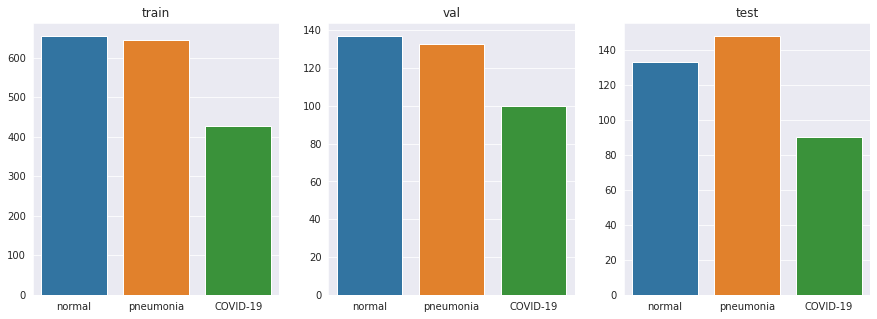

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(np.log(BATCH_SIZE) / np.log(2), np.log(BATCH_SIZE) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n][0] == 1:
            plt.title("NORMAL")
        elif label_batch[n][1] == 1:
            plt.title("PNEUMONIA")
        elif label_batch[n][2] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


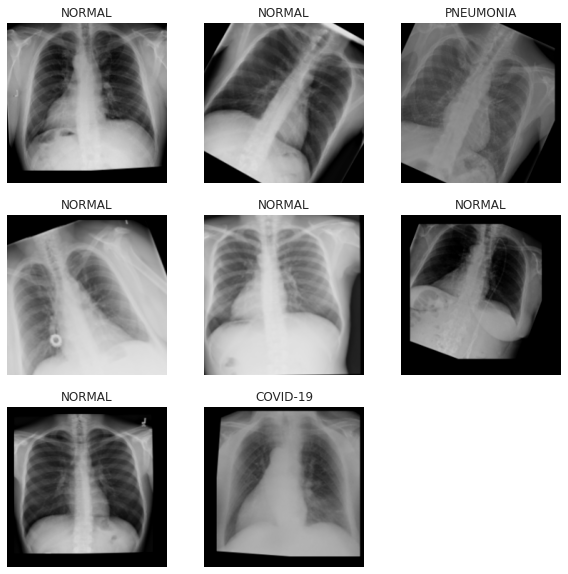

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())
print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for pneumonia: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.88
Weight for pneumonia: 	0.89
Weight for COVID-19: 	1.35


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

### Early stopping


In [ ]:
# TODO checkpoint = ModelCheckpoint("x-covid.h5", monitor=monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## ResNet50V2
V1  
Kaiming He, et al.
**Deep residual learning for image recognition.**
(2016)
[Google Scholar](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)

V2  
Kaiming He, et al.
**Identity mappings in deep residual networks.** 
(2016)
[Google Scholar](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
def resnet50_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet = ResNet50V2(include_top = False,
                       weights = 'imagenet',
                       input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),)
    
    # make resnet layers trainable
    resnet.trainable = True
    # TODO try freeze first pretrained layers, train later layers
    #for layer in resnet.layers[:103]:
    #    layer.trainable=False
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        # add pretrained resnet layer to model
        resnet,
        GlobalAveragePooling2D(name='AvgPool'),
        # add dropout (inspired by inception-resnet-v2)
        Dropout(0.2, name='Dropout'),
        # add classification layer for normal/pneumonia/COVID-19
        Dense(units=3, activation='softmax', name='Output'),
    ], name='ResNet50')
    
    return model

In [ ]:
# TODO try out finding good split for trainable part
#resnet50.layers[0].layers[104]
#len([layer for layer in resnet50.layers[0].layers if isinstance(layer, keras.layers.Conv2D)])

In [ ]:
resnet50 = resnet50_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50.compile(
    # very low learning rate to adapt pretrained weights to new data without
    # overfitting because of small dataset
    optimizer=Adam(lr=1e-5), # default: 1e-3
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [ ]:
resnet50.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 3)                 6147      
Total params: 23,570,947
Trainable params: 23,525,507
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
history_resnet = resnet50.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay, early_stopping],
)

Epoch 1/20
215/215 [==============================] - 29s 137ms/step - loss: 0.8468 - accuracy: 0.6424 - precision: 0.7386 - recall: 0.4517 - val_loss: 0.7082 - val_accuracy: 0.6929 - val_precision: 0.7516 - val_recall: 0.6413
Epoch 2/20
215/215 [==============================] - 28s 130ms/step - loss: 0.6083 - accuracy: 0.7674 - precision: 0.8182 - recall: 0.7064 - val_loss: 0.5681 - val_accuracy: 0.7799 - val_precision: 0.8301 - val_recall: 0.6902
Epoch 3/20
215/215 [==============================] - 28s 132ms/step - loss: 0.5444 - accuracy: 0.7860 - precision: 0.8243 - recall: 0.7500 - val_loss: 0.4840 - val_accuracy: 0.8043 - val_precision: 0.8515 - val_recall: 0.7636
Epoch 4/20
215/215 [==============================] - 28s 132ms/step - loss: 0.4956 - accuracy: 0.8058 - precision: 0.8267 - recall: 0.7738 - val_loss: 0.4062 - val_accuracy: 0.8533 - val_precision: 0.8746 - val_recall: 0.8152
Epoch 5/20
215/215 [==============================] - 28s 130ms/step - loss: 0.4838 - accura

### Evaluation

###### Visualize performance

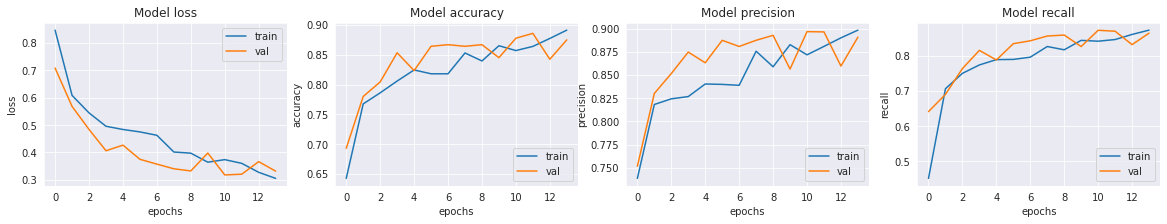

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet.history[met])
    ax[i].plot(history_resnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

47/47 [==============================] - 1s 29ms/step - loss: 0.4479 - accuracy: 0.8410 - precision: 0.8564 - recall: 0.8356
Loss of the model is -  0.44794580340385437
Accuracy of the model is -  84.09703373908997 %
Precision of the model is -  0.8563535809516907
Recall of the model is -  0.835579514503479


## EfficientNet-B4
Mingxing Tan, Quoc V. Le.
**EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.**
(2019)
[Google Scholar](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=EfficientNet%3A+Rethinking+Model+Scaling+for+Convolutional+Neural+Networks&btnG=)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

def effnetb4_builder():
    # load pretrained EfficientNetB4 (ImageNet) without output
    effnet = EfficientNetB4(include_top = False,
                       weights = 'imagenet',
                       input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),)
    
    # make resnet layers trainable
    effnet.trainable = True
    # TODO try freeze first pretrained layers, train later layers
    #for layer in reffnet.layers[:103]:
    #    layer.trainable=False
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        # add pretrained effnet layer to model
        effnet,
        GlobalAveragePooling2D(name='AvgPool'),
        # add dropout (inspired by inception-resnet-v2)
        Dropout(0.2, name='Dropout'),
        # add classification layer for normal/pneumonia/COVID-19
        Dense(units=3, activation='softmax', kernel_initializer=DENSE_KERNEL_INITIALIZER, name='Output'),
    ], name='EfficientNetB4')
    
    return model

In [ ]:
# TODO try out finding good split for trainable part
#effnetb4.layers[0].layers[104]
#len([layer for layer in effnetb4.layers[0].layers if isinstance(layer, keras.layers.Conv2D)])

In [ ]:
effnetb4 = effnetb4_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

effnetb4.compile(
    # very low learning rate to adapt pretrained weights to new data without
    # overfitting because of small dataset
    optimizer=Adam(lr=1e-5), # default: 1e-3
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [ ]:
effnetb4.summary()

Model: "EfficientNetB4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 1792)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
Output (Dense)               (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________


### Training

In [ ]:
history_effnetb4 = effnetb4.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay, early_stopping],
)

Epoch 1/20
215/215 [==============================] - 53s 248ms/step - loss: 0.2352 - accuracy: 0.9169 - precision: 0.9246 - recall: 0.9122 - val_loss: 0.8834 - val_accuracy: 0.6332 - val_precision: 0.6439 - val_recall: 0.6141
Epoch 2/20
215/215 [==============================] - 53s 246ms/step - loss: 0.2346 - accuracy: 0.9140 - precision: 0.9216 - recall: 0.9093 - val_loss: 0.9648 - val_accuracy: 0.6168 - val_precision: 0.6236 - val_recall: 0.6033
Epoch 3/20
215/215 [==============================] - 53s 247ms/step - loss: 0.2445 - accuracy: 0.9163 - precision: 0.9209 - recall: 0.9076 - val_loss: 0.3578 - val_accuracy: 0.8560 - val_precision: 0.8643 - val_recall: 0.8478
Epoch 4/20
215/215 [==============================] - 53s 248ms/step - loss: 0.2300 - accuracy: 0.9180 - precision: 0.9239 - recall: 0.9110 - val_loss: 0.5323 - val_accuracy: 0.7772 - val_precision: 0.7915 - val_recall: 0.7636
Epoch 5/20
215/215 [==============================] - 53s 247ms/step - loss: 0.2177 - accura

### Evaluation

###### Visualize performance

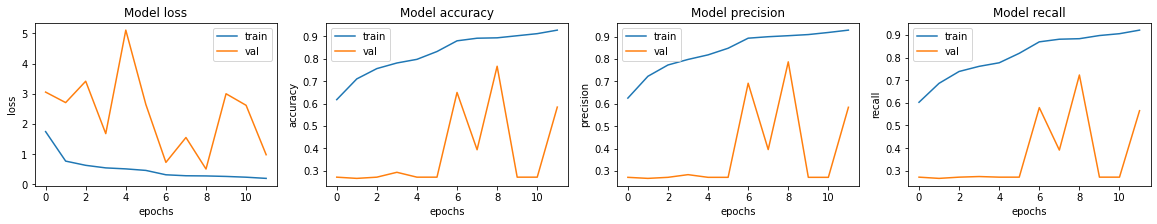

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_effnetb4.history[met])
    ax[i].plot(history_effnetb4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Predict on test set

In [ ]:
loss, acc, prec, rec = effnetb4.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

47/47 [==============================] - 6s 131ms/step - loss: 0.5612 - accuracy: 0.7817 - precision: 0.8012 - recall: 0.7493
Loss of the model is -  0.5611507892608643
Accuracy of the model is -  78.16711664199829 %
Precision of the model is -  0.801152765750885
Recall of the model is -  0.7493261694908142


## DarkNet (Based on DarkCovidNet)

Tulin Ozturk, et al.
**Automated detection of COVID-19 cases using deep neural networks with X-ray images.**
(2020)
[Github](https://github.com/ieee8023/covid-chestxray-dataset)
[Google Scholar](https://scholar.google.com/scholar_lookup?title=Automated%20detection%20of%20COVID-19%20cases%20using%20deep%20neural%20networks%20with%20X-ray%20images&publication_year=2020&author=T.%20Ozturk)

### Model definition

DarkNet block definition

In [ ]:
def darknet_block(filters, kernel_size=3, strides=1):
    block = Sequential([
        ZeroPadding2D(padding=(1, 1)),
        Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='valid', use_bias=False),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
    ])
    return block

def triple_conv(prev, filters):
    return Sequential([
        darknet_block(filters),
        darknet_block(prev, kernel_size=1),  
        darknet_block(filters)
    ])

def max_pool():
    return MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')

In [ ]:
def darknet_builder():
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        darknet_block(8),
        max_pool(),
        darknet_block(16),
        max_pool(),
        triple_conv(16, 32),
        max_pool(),
        triple_conv(32, 64),
        max_pool(),
        triple_conv(64, 128),
        max_pool(),
        triple_conv(128, 256),
        darknet_block(128, kernel_size=1),
        darknet_block(256),
        darknet_block(3),
        Flatten(),
        Dense(units=3, activation='softmax')
    ], name='DarkNet')
    
    return model

In [ ]:
darknet = darknet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

darknet.compile(
    optimizer=Adam(lr=0.001), # default: 0.001
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [ ]:
darknet.summary()
darknet.layers[4].layers[1].summary()

Model: "DarkNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 8)       248       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 112, 112, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 58, 58, 32)        10048     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 31, 31, 64)        3955

### Training

In [ ]:
history_darknet = darknet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay, early_stopping],
)

Epoch 1/10
215/215 [==============================] - 20s 94ms/step - loss: 1.1122 - accuracy: 0.4186 - precision: 0.4950 - recall: 0.1453 - val_loss: 1.2696 - val_accuracy: 0.3560 - val_precision: 0.3581 - val_recall: 0.3533
Epoch 2/10
215/215 [==============================] - 19s 90ms/step - loss: 0.9878 - accuracy: 0.5355 - precision: 0.6267 - recall: 0.3494 - val_loss: 1.0085 - val_accuracy: 0.4701 - val_precision: 0.5357 - val_recall: 0.3668
Epoch 3/10
215/215 [==============================] - 19s 90ms/step - loss: 0.9199 - accuracy: 0.5727 - precision: 0.6604 - recall: 0.4500 - val_loss: 0.8613 - val_accuracy: 0.6196 - val_precision: 0.6755 - val_recall: 0.4864
Epoch 4/10
215/215 [==============================] - 19s 89ms/step - loss: 0.8976 - accuracy: 0.5959 - precision: 0.6846 - recall: 0.4669 - val_loss: 0.8107 - val_accuracy: 0.6359 - val_precision: 0.6667 - val_recall: 0.5761
Epoch 5/10
215/215 [==============================] - 19s 89ms/step - loss: 0.8478 - accuracy: 0

### Evaluation

###### Visualize performance

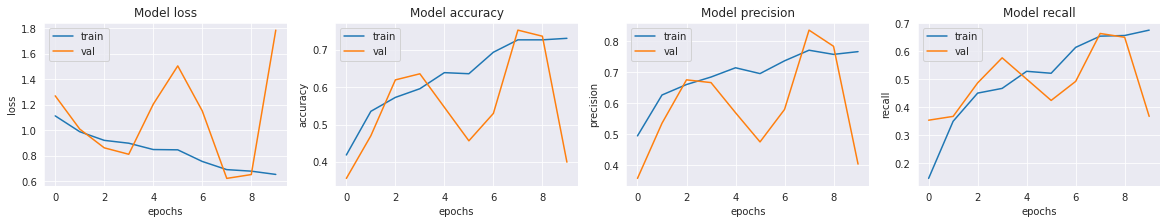

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_darknet.history[met])
    ax[i].plot(history_darknet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Predict on test set

In [ ]:
loss, acc, prec, rec = darknet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

47/47 [==============================] - 1s 12ms/step - loss: 1.7239 - accuracy: 0.3720 - precision: 0.3720 - recall: 0.3288
Loss of the model is -  1.7238898277282715
Accuracy of the model is -  37.19676434993744 %
Precision of the model is -  0.37195122241973877
Recall of the model is -  0.328840970993042
